# Results

In [1]:
%config InlineBackend.figure_formats = ['svg']
%matplotlib inline

In [2]:
import os
from functools import partial

import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, Normalize

import numpy as np
import pandas as pd

from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.impute import KNNImputer
from sklearn.pipeline import Pipeline

from helpers import smooth_model_outputs, subsample_train, score_priority

from sklearn.utils.class_weight import compute_sample_weight
from xgboost import XGBClassifier

from vassi.classification import (
    plot_confusion_matrix,
    predict,
)
from vassi.config import cfg
from vassi.features import DataFrameFeatureExtractor
from vassi.io import from_yaml, load_dataset, to_cache, from_cache, save_data, load_data
from vassi.classification.results import DatasetClassificationResult
from vassi.utils import Experiment
from vassi.sliding_metrics import (
    SlidingWindowAggregator,
    get_window_slices,
    metrics,
)

import vassi._manuscript_utils as manuscript_utils
from vassi import visualization as vis

from interactive_table import Table

In [3]:
cfg.key_keypoints = "pose"
cfg.key_timestamp = "time_stamp"

cfg.trajectory_keys = ("pose", "time_stamp")

## Example train and test run

In [4]:
# load training and test datasets
dataset_full = load_dataset(
    "cichlids",
    directory="../../datasets/social_cichlids",
    target="dyad",
    background_category="none",
)

# fixed random_state, the train test split always uses random_state=1
dataset_train, dataset_test = dataset_full.split(
    0.8,
    random_state=1,  
)

# initialize feature extraction pipeline
time_scales, slices = get_window_slices(3, time_scales=(91,))
aggregator = ColumnTransformer(
    [
        (
            "aggregate",
            SlidingWindowAggregator(
                [metrics.median, metrics.q10, metrics.q90], max(time_scales), slices
            ),
            make_column_selector(),
        ),
        ("original", "passthrough", make_column_selector()),
    ],
)

pipeline = Pipeline(
    [("impute", KNNImputer()), ("aggregate", aggregator)]
).set_output(transform="pandas")

extractor = DataFrameFeatureExtractor(
    cache_directory="/media/paul/Data2/cichlids_cache",
    pipeline=pipeline,
    refit_pipeline=True,
).read_yaml("config_file-cichlids.yaml")

# and load optimized postprocessing parameters
best_parameters = from_yaml("optimization-summary.yaml")

priority_function = partial(
    score_priority,
    weight_max_probability=best_parameters["weight_max_probability"],
    weight_mean_probability=1 - best_parameters["weight_max_probability"],
)
best_thresholds = [best_parameters[f"threshold-{category}"] for category in dataset_test.categories]

# optionally, run a full example run with training and predictions
run_example_run = False

if run_example_run:
    # set a fixed random state for reproducible results
    random_state = np.random.default_rng(1)
    
    # subsample dataset and encode target from string to numeric
    X, y = subsample_train(
        dataset_train,
        extractor,
        random_state=random_state,
        log=None,
    )
    y = dataset_train.encode(y)
    
    # specify and fit classification model
    classifier = XGBClassifier(n_estimators=1000, random_state=random_state).fit(
        X.to_numpy(), y, sample_weight=compute_sample_weight("balanced", y)
    )
    
    # use model for predictions on the test dataset
    test_result = predict(
        dataset_test,
        classifier,
        extractor,
        log=None,
    )

    # postprocessing and f1 scores
    f1_scores = (
        test_result
        .smooth(partial(smooth_model_outputs, best_parameters), decision_thresholds=best_thresholds)
        .remove_overlapping_predictions(
            priority_function=priority_function,
            prefilter_recipient_bouts=best_parameters["prefilter_recipient_bouts"],
            max_bout_gap=best_parameters["max_bout_gap"],
            max_allowed_bout_overlap=best_parameters["max_allowed_bout_overlap"],
        )
        .score()
    )

2025-06-11 13:55:13.402 [WARNING ] Loading categories (approach, chase, dart_bite, frontal_display, lateral_display, none, quiver) from observations file, specify categories argument if incomplete.
2025-06-11 13:55:26.852 [WARNING ] Time scales adjusted to match num_windows_per_scale: (91,) -> [93].


In [5]:
(
    dataset_full
    .observations.groupby("category")
    .aggregate({"duration": "sum"})
)

,duration
category,
approach,7699
chase,7412
dart_bite,12318
frontal_display,39569
lateral_display,14179
none,24910846
quiver,10053


## Evaluation

Uncomment the code in the following cell to run 20 training and test runs with different random states.

Note that this takes quite a long time. The `evaluation-cichlids.py` script allows to run the same code in parallel using MPI on appropriate hardware (e.g., a high-performance computing cluster).

In [6]:
# from tqdm.auto import tqdm

# cache_directory = "/media/paul/Data1/samples_cache"
# experiment = Experiment(20, random_state=1)

# for run in tqdm(experiment, total=experiment.num_runs):
    
#     # X, y = subsample_train(
#     #     dataset_train,
#     #     extractor,
#     #     random_state=experiment.random_state,
#     #     log=None,
#     # )
#     # y = dataset_train.encode(y)

#     # classifier = XGBClassifier(n_estimators=1000, random_state=experiment.random_state).fit(
#     #     X.to_numpy(), y, sample_weight=compute_sample_weight("balanced", y)
#     # )

#     classifier = from_cache(os.path.join(cache_directory, f"clf_{run:02d}.cache"))

#     summary = []
#     y = {"true": {}, "pred": {}}

#     test_result = (
#         predict(dataset_test, classifier, extractor, log=None)
#         .remove_overlapping_predictions(
#             priority_function=priority_function,
#             prefilter_recipient_bouts=best_parameters["prefilter_recipient_bouts"],
#             max_bout_gap=best_parameters["max_bout_gap"],
#             max_allowed_bout_overlap=best_parameters["max_allowed_bout_overlap"],
#         )
#     )
#     summary.append(
#         manuscript_utils.summarize_scores(
#             test_result,
#             foreground_categories=dataset_test.foreground_categories,
#             run=run,
#             postprocessing_step="model_outputs",
#         )
#     )

#     test_result = (
#         test_result.smooth(partial(smooth_model_outputs, best_parameters))
#         .remove_overlapping_predictions(
#             priority_function=priority_function,
#             prefilter_recipient_bouts=best_parameters["prefilter_recipient_bouts"],
#             max_bout_gap=best_parameters["max_bout_gap"],
#             max_allowed_bout_overlap=best_parameters["max_allowed_bout_overlap"],
#         )
#     )
#     summary.append(
#         manuscript_utils.summarize_scores(
#             test_result,
#             foreground_categories=dataset_test.foreground_categories,
#             run=run,
#             postprocessing_step="smoothed",
#         )
#     )

#     test_result = (
#         test_result.threshold(best_thresholds, default_decision="none")
#         .remove_overlapping_predictions(
#             priority_function=priority_function,
#             prefilter_recipient_bouts=best_parameters["prefilter_recipient_bouts"],
#             max_bout_gap=best_parameters["max_bout_gap"],
#             max_allowed_bout_overlap=best_parameters["max_allowed_bout_overlap"],
#         )
#     )
#     summary.append(
#         manuscript_utils.summarize_scores(
#             test_result,
#             foreground_categories=dataset_test.foreground_categories,
#             run=run,
#             postprocessing_step="thresholded",
#         )
#     )

#     summary = pd.concat(summary, ignore_index=True)

#     y["true"]["timestamp"] = test_result.y_true_numeric
#     y["pred"]["timestamp"] = test_result.y_pred_numeric
#     y["true"]["annotation"] = dataset_test.encode(test_result.annotations["category"].to_numpy())
#     y["pred"]["annotation"] = dataset_test.encode(test_result.annotations["predicted_category"].to_numpy())
#     y["true"]["prediction"] = dataset_test.encode(test_result.predictions["true_category"].to_numpy())
#     y["pred"]["prediction"] = dataset_test.encode(test_result.predictions["category"].to_numpy())

#     experiment.add((summary, y))

# summary = pd.concat([summary for summary, _ in experiment.collect().values()], ignore_index=True)
# confusion = [y for _, y in experiment.collect().values()]

# for run, confusion_data in enumerate(confusion):
#     save_data("results.h5", confusion_data["true"], os.path.join(f"run_{run:02d}", "true"))
#     save_data("results.h5", confusion_data["pred"], os.path.join(f"run_{run:02d}", "pred"))
# save_data("results.h5", {"runs": np.array([f"run_{run:02d}" for run in range(len(confusion))])})
# summary.to_hdf("results.h5", key="summary")
# test_result.to_h5("results.h5", dataset_name="test_dataset")

In [7]:
# instead, just load the results

summary = pd.read_hdf("results.h5", key="summary")
confusion = [load_data("results.h5", run) for run in load_data("results.h5", "runs")]
test_result = DatasetClassificationResult.from_h5("results.h5", dataset_name="test_dataset")

## Interaction networks and timeline plot

In [8]:
# shorter category labels if necessary
category_labels = ["appr", "chase", "bite", "front", "lat", "none", "quiv"]

# corresponding colors
colors = ["#66C2A5", "#B84D3D", "#FC8D62", "#4C6688", "#8DA0CB", "#dddddd", "#EEA5CC"]

# and additional keyword arguments for all boxes in the following visualizations
box_kwargs = {"lw": 0, "joinstyle": "round", "alpha": 0.5}

In [9]:
from vassi.classification.predict import k_fold_predict
from vassi.logging import set_logging_level
from vassi.io import save_dataset
from tqdm.auto import tqdm

run_k_fold = False

if run_k_fold:
    # this takes ~2h to compute features for all dyads
    for sampleable in tqdm([sampleable for _, group in dataset_full for _, sampleable in group]):
        sampleable.sample_X(extractor)
    
    # but makes this quicker in return (still takes 6h to finish)
    k_fold_result = k_fold_predict(
        dataset_full,
        extractor,
        XGBClassifier(n_estimators=1000),
        k=5,
        random_state=1,  # fixed for reproducibility
        sampling_function=subsample_train,
        balance_sample_weights=True,
        log=set_logging_level("info"),
    )

    # postprocessing with optimal parameters
    dataset_cv = (
        k_fold_result
        .smooth(partial(smooth_model_outputs, best_parameters), decision_thresholds=best_thresholds)
        .remove_overlapping_predictions(
            priority_function=priority_function,
            prefilter_recipient_bouts=best_parameters["prefilter_recipient_bouts"],
            max_bout_gap=best_parameters["max_bout_gap"],
            max_allowed_bout_overlap=best_parameters["max_allowed_bout_overlap"],
        )
        .to_dataset(
            trajectories={identifier: group.trajectories for identifier, group in dataset_full},
            background_category="none",
        )
    )

    # save to datasets directory
    save_dataset(
        dataset_cv,
        dataset_name="k_fold_predictions",
        directory="../../datasets/social_cichlids",
        observation_suffix="predictions",
    )

In [10]:
# or just load the cross-validation predictions (saved as a dataset)

dataset_cv = load_dataset(
    "k_fold_predictions",
    directory="../../datasets/social_cichlids",
    target="dyad",
    observation_suffix="predictions",
    background_category="none",
)

2025-06-11 13:55:34.608 [WARNING ] Loading categories (approach, chase, dart_bite, frontal_display, lateral_display, none, quiver) from observations file, specify categories argument if incomplete.


In [11]:
# dyadic interaction matrices, both annotated and predicted

group_annotated = dataset_full.select("GH030861")
group_predicted = dataset_cv.select("GH030861")
                              
locations = np.array(
    [
        np.mean(group_annotated.trajectories[individual][cfg.key_keypoints], axis=(0, 1))
        for individual in group_annotated.individuals
    ]
)
locations = manuscript_utils.adjust_node_positions_repulsion_vectorized(locations, min_distance=200, step=1)

interaction_matrices_annotated = manuscript_utils.dyadic_interactions(group_annotated, kind="count")
counts_annotated = np.array(list(interaction_matrices_annotated.values())).ravel()
counts_annotated = counts_annotated[counts_annotated > 0]

interaction_matrices_predicted = manuscript_utils.dyadic_interactions(group_predicted, kind="count")
counts_predicted = np.array(list(interaction_matrices_predicted.values())).ravel()
counts_predicted = counts_predicted[counts_predicted > 0]

counts = np.concatenate([counts_annotated, counts_predicted])

observations_group = dataset_test.select("GH030861").observations
observations_group = observations_group[observations_group["category"] != dataset_test.background_category]

cmap = LinearSegmentedColormap.from_list("gray_to_black", ["lightgray", "black"])
norm = Normalize(vmin=np.log(counts).min(), vmax=np.log(counts).max())

actor_counts = observations_group.groupby("actor", as_index=False).aggregate(count=("recipient", "count")).sort_values("count", ascending=False)
actor = actor_counts["actor"].iloc[0]

recipient_counts = observations_group[observations_group["actor"] == actor].groupby("recipient", as_index=False).aggregate(count=("recipient", "count")).sort_values("count", ascending=False)
recipients = recipient_counts["recipient"].tolist()[:3]

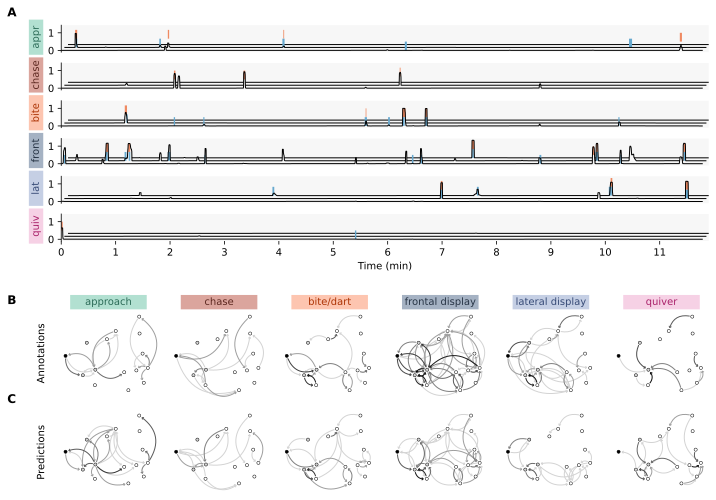

In [12]:
num_steps = 3
num_categories = len(dataset_test.categories)

figsize = (9, 6.5)
fig = plt.figure(figsize=figsize)

panel = vis.Panel(*figsize, extent=(0, 0, *figsize))

top, middle = panel.divide(sizes_absolute=[0, 2.5], orientation="vertical", spacing_absolute=1)

panels_timeline = top.divide(sizes=[1] * len(dataset_test.foreground_categories), spacing_absolute=0.15, orientation="vertical")

row_1, row_2 = middle.divide(sizes=[1, 1], orientation="vertical", spacing=0.1)

panels_row_1 = row_1.divide(sizes=[1] * len(group_annotated.foreground_categories), spacing=0.025, orientation="horizontal")
panels_row_2 = row_2.divide(sizes=[1] * len(group_annotated.foreground_categories), spacing=0.025, orientation="horizontal")

labels = {0: "A", 1: "B", 2: "C"}

axes_timeline = [panel.get_ax(fig, label=labels.pop(0, None)) for panel in panels_timeline]
axes_annotated = [panel.get_ax(fig, label=labels.pop(1, None), spines=[False] * 4) for panel in panels_row_1]
axes_predicted = [panel.get_ax(fig, label=labels.pop(2, None), spines=[False] * 4) for panel in panels_row_2]

foreground = np.isin(dataset_test.categories, dataset_test.foreground_categories)

for idx, recipient in enumerate(recipients):

    dyad_results = test_result.classification_results["GH030861"].classification_results[(actor, recipient)]  # GH030861: 6, 9
    manuscript_utils.plot_classification_timeline_multiple(
        dyad_results.predictions,
        dataset_test.foreground_categories,
        annotations=dyad_results.annotations,
        timestamps=dyad_results.timestamps,
        y_proba_smoothed=dyad_results.y_proba_smoothed[:, foreground],
        interval=(-np.inf, np.inf),
        x_tick_step=(30 * 60),
        x_tick_conversion=lambda ticks: (np.asarray(ticks) / (30 * 60)).astype(int),
        y_offset=idx / 6,
        x_offset=idx * 120,
        zorder=-idx,
        axes=axes_timeline,
    )

for label, ax, color in zip(
    np.array(category_labels)[foreground],
    axes_timeline,
    np.array(colors)[foreground],
):
    ax.set_ylabel(None)
    vis.add_ytick_box(0.5 + 3 / (6 * 2), 2, ax, color=color, text=label, offset_in_inches=0.25, **box_kwargs)
ax.set_xlabel("Time (min)")

####

for idx, category in enumerate(group_annotated.foreground_categories):
    manuscript_utils.draw_network(
        axes_annotated[idx], interaction_matrices_annotated[category], locations, cmap, norm,
        fc=[("black" if ind == actor else ("lightgray" if ind in recipients else "white")) for ind in group_annotated.individuals],
    )
    manuscript_utils.draw_network(
        axes_predicted[idx], interaction_matrices_predicted[category], locations, cmap, norm,
        fc=[("black" if ind == actor else ("lightgray" if ind in recipients else "white")) for ind in group_annotated.individuals],
    )
    
    axes_annotated[idx].set_xticks([])
    axes_predicted[idx].set_xticks([])
    axes_annotated[idx].set_yticks([])
    axes_predicted[idx].set_yticks([])

    if idx > 0:
        axes_annotated[idx].sharex(axes_annotated[0])
        axes_predicted[idx].sharex(axes_predicted[0])
        axes_annotated[idx].sharey(axes_annotated[0])
        axes_predicted[idx].sharey(axes_predicted[0])
        
axes_annotated[0].set_ylabel("Annotations", labelpad=15)
axes_predicted[0].set_ylabel("Predictions", labelpad=15)

for ax, color, category in zip(
    axes_annotated,
    ["#66C2A5", "#B84D3D", "#FC8D62", "#4C6688", "#8DA0CB", "#EEA5CC"],
    group_annotated.foreground_categories,
):
    if category == "dart_bite":
        category = "bite/dart"
    category = category.replace("_", " ")
    vis.add_xtick_box(np.mean(ax.get_xlim()), np.diff(ax.get_xlim())[0] - 400, ax, offset_in_inches=0.05, y="top", text=category, color=color, **box_kwargs)

## Prediction-based F1 scores

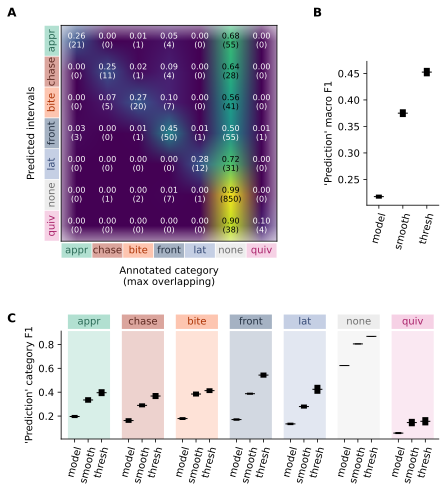

In [13]:
scores = manuscript_utils.aggregate_scores(summary, "prediction_f1", categories=dataset_test.categories)
num_steps = 3
num_categories = len(dataset_test.categories)

figsize = (5.25, 5.75)
fig = plt.figure(figsize=figsize)

panel = vis.Panel(*figsize, extent=(0, 0, *figsize))
top, bottom = panel.divide(sizes_absolute=[3, 0], spacing_absolute=1.25, orientation="vertical")
panels_top = top.divide(sizes_absolute=[3, 0], spacing_absolute=1.25, orientation="horizontal")

ax_confusion = panels_top[0].get_ax(fig, label="A", spines=[True] * 4)
right = panels_top[1].divide(sizes_absolute=[0.5, 2, 0], spacing=0, orientation="vertical")
right[0].get_ax(fig, label="B").axis("off")  # emtpy axes aligned with confusion matrix
ax_macro_f1 = right[1].get_ax(fig)  # actual axes for errorbars
ax_category_f1 = bottom.get_ax(fig, label="C")

####

plot_confusion_matrix(
    np.array([y["pred"]["prediction"] for y in confusion], dtype=object),
    np.array([y["true"]["prediction"] for y in confusion], dtype=object),
    show_colorbar=False,
    ax=ax_confusion,
)
ax_confusion.set_ylabel("Predicted intervals", labelpad=25)
ax_confusion.set_xlabel("Annotated category\n(max overlapping)", labelpad=25)

vis.add_xtick_boxes(range(len(category_labels)), 0.975, ax_confusion, labels=category_labels, colors=colors, **box_kwargs)
vis.add_ytick_boxes(range(len(category_labels)), 0.975, ax_confusion, labels=category_labels, colors=colors, **box_kwargs)

####

manuscript_utils.plot_errorbars(
    ax_macro_f1,
    *scores["macro-all"].to_numpy().T,
    ylabel="'Prediction' macro F1",
)

x = [x for idx in range(num_categories) for x in np.arange(num_steps) + idx * num_categories / 1.75]
means, stds = pd.concat([scores[category] for category in dataset_test.categories]).to_numpy().T
manuscript_utils.plot_errorbars(
    ax_category_f1,
    means,
    stds,
    x=x,
    padding=1,
    xticklabels=("model", "smooth", "thresh") * num_categories,
    ylabel="'Prediction' category F1",
)
for (idx, category), color in zip(enumerate(category_labels), colors):
    x_left = x[num_steps * idx] - 0.5
    x_right = x[num_steps * (idx + 1) - 1] + 0.625
    ax_category_f1.axvspan(x_left, x_right, color=color, alpha=0.25, lw=0)
    vis.add_xtick_box(
        (x_left + x_right) / 2,
        x_right - x_left,
        ax_category_f1,
        y="top",
        text=category,
        color=color,
        **box_kwargs,
    )

## Timestamp-based F1 scores

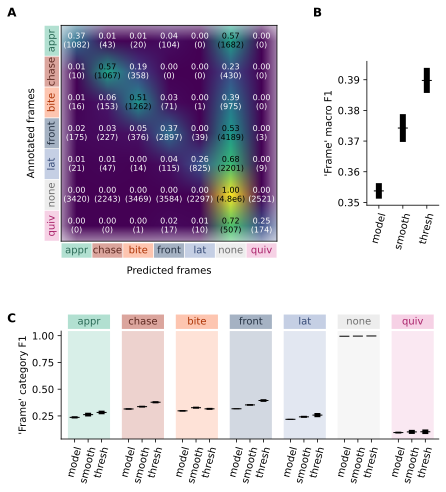

In [14]:
scores = manuscript_utils.aggregate_scores(summary, "timestamp_f1", categories=dataset_test.categories)
num_steps = 3
num_categories = len(dataset_test.categories)

figsize = (5.25, 5.75)
fig = plt.figure(figsize=figsize)

panel = vis.Panel(*figsize, extent=(0, 0, *figsize))
top, bottom = panel.divide(sizes_absolute=[3, 0], spacing_absolute=1.25, orientation="vertical")
panels_top = top.divide(sizes_absolute=[3, 0], spacing_absolute=1.25, orientation="horizontal")

ax_confusion = panels_top[0].get_ax(fig, label="A", spines=[True] * 4)
right = panels_top[1].divide(sizes_absolute=[0.5, 2, 0], spacing=0, orientation="vertical")
right[0].get_ax(fig, label="B").axis("off")  # emtpy axes aligned with confusion matrix
ax_macro_f1 = right[1].get_ax(fig)  # actual axes for errorbars
ax_category_f1 = bottom.get_ax(fig, label="C")

####

plot_confusion_matrix(
    [y["true"]["timestamp"] for y in confusion],
    [y["pred"]["timestamp"] for y in confusion],
    show_colorbar=False,
    ax=ax_confusion,
)

ax_confusion.set_xlabel("Predicted frames", labelpad=25)
ax_confusion.set_ylabel("Annotated frames", labelpad=25)

vis.add_xtick_boxes(range(len(category_labels)), 0.975, ax_confusion, labels=category_labels, colors=colors, **box_kwargs)
vis.add_ytick_boxes(range(len(category_labels)), 0.975, ax_confusion, labels=category_labels, colors=colors, **box_kwargs)

####

manuscript_utils.plot_errorbars(
    ax_macro_f1,
    *scores["macro-all"].to_numpy().T,
    ylabel="'Frame' macro F1",
)

x = [x for idx in range(num_categories) for x in np.arange(num_steps) + idx * num_categories / 1.75]
means, stds = pd.concat([scores[category] for category in dataset_test.categories]).to_numpy().T
manuscript_utils.plot_errorbars(
    ax_category_f1,
    means,
    stds,
    x=x,
    padding=1,
    xticklabels=("model", "smooth", "thresh") * num_categories,
    ylabel="'Frame' category F1",
)
for (idx, category), color in zip(enumerate(category_labels), colors):
    x_left = x[num_steps * idx] - 0.5
    x_right = x[num_steps * (idx + 1) - 1] + 0.625
    ax_category_f1.axvspan(x_left, x_right, color=color, alpha=0.25, lw=0)
    vis.add_xtick_box(
        (x_left + x_right) / 2,
        x_right - x_left,
        ax_category_f1,
        y="top",
        text=category,
        color=color,
        **box_kwargs,
    )

## Annotation-based F1 scores

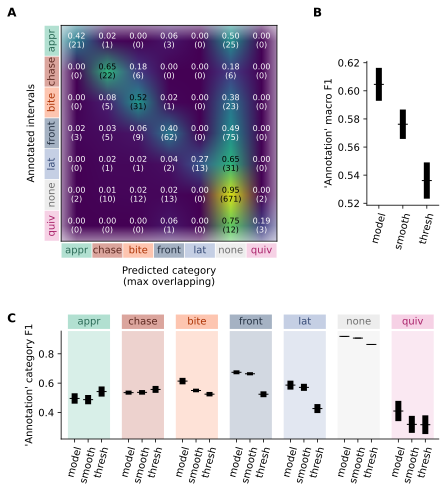

In [15]:
scores = manuscript_utils.aggregate_scores(summary, "annotation_f1", categories=dataset_test.categories)
num_steps = 3
num_categories = len(dataset_test.categories)

figsize = (5.25, 5.75)
fig = plt.figure(figsize=figsize)

panel = vis.Panel(*figsize, extent=(0, 0, *figsize))
top, bottom = panel.divide(sizes_absolute=[3, 0], spacing_absolute=1.25, orientation="vertical")
panels_top = top.divide(sizes_absolute=[3, 0], spacing_absolute=1.25, orientation="horizontal")

ax_confusion = panels_top[0].get_ax(fig, label="A", spines=[True] * 4)
right = panels_top[1].divide(sizes_absolute=[0.5, 2, 0], spacing=0, orientation="vertical")
right[0].get_ax(fig, label="B").axis("off")  # emtpy axes aligned with confusion matrix
ax_macro_f1 = right[1].get_ax(fig)  # actual axes for errorbars
ax_category_f1 = bottom.get_ax(fig, label="C")

####

plot_confusion_matrix(
    [y["true"]["annotation"] for y in confusion],
    [y["pred"]["annotation"] for y in confusion],
    show_colorbar=False,
    ax=ax_confusion,
)
ax_confusion.set_xlabel("Predicted category\n(max overlapping)", labelpad=25)
ax_confusion.set_ylabel("Annotated intervals", labelpad=25)

vis.add_xtick_boxes(range(len(category_labels)), 0.975, ax_confusion, labels=category_labels, colors=colors, **box_kwargs)
vis.add_ytick_boxes(range(len(category_labels)), 0.975, ax_confusion, labels=category_labels, colors=colors, **box_kwargs)

####

manuscript_utils.plot_errorbars(
    ax_macro_f1,
    *scores["macro-all"].to_numpy().T,
    ylabel="'Annotation' macro F1",
)

x = [x for idx in range(num_categories) for x in np.arange(num_steps) + idx * num_categories / 1.75]
means, stds = pd.concat([scores[category] for category in dataset_test.categories]).to_numpy().T
manuscript_utils.plot_errorbars(
    ax_category_f1,
    means,
    stds,
    x=x,
    padding=1,
    xticklabels=("model", "smooth", "thresh") * num_categories,
    ylabel="'Annotation' category F1",
)
for (idx, category), color in zip(enumerate(category_labels), colors):
    x_left = x[num_steps * idx] - 0.5
    x_right = x[num_steps * (idx + 1) - 1] + 0.625
    ax_category_f1.axvspan(x_left, x_right, color=color, alpha=0.25, lw=0)
    vis.add_xtick_box(
        (x_left + x_right) / 2,
        x_right - x_left,
        ax_category_f1,
        y="top",
        text=category,
        color=color,
        **box_kwargs,
    )

## Predictions vs association

In [16]:
annotations = dataset_test.observations
predictions = test_result.predictions

In [17]:
dyads = [(group_identifier, *identifier) for group_identifier, group in dataset_test for identifier in group.identifiers]

In [18]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

from vassi import features

In [19]:
average_body_length = np.mean(
    [
        features.keypoint_distances(trajectory, keypoints_1=(0, 1), keypoints_2=(1, 2), element_wise=True).sum(axis=1).mean()
        for _, group in dataset_test
        for trajectory in group.trajectories.values()
    ]
)

# just a one to one mapping, but could also group multiple categories
category_subsets = {
    category: [category]  
    for category in dataset_test.foreground_categories
}

# three average body length factors for sensibility analysis for proximitry vs predicted counts
for distance_factor in [1, 5, 3]:

    aggregated_counts = []
    
    for idx, (subset, categories_subset) in enumerate(category_subsets.items()):
    
        identifier_columns = ["group", "actor", "recipient"]
        
        annotated_counts = pd.DataFrame(dyads, columns=identifier_columns)
        annotated_counts["count"] = 0
        annotated_counts["duration"] = 0
        annotated_counts["duration_associated"] = 0
        annotated_counts = annotated_counts.set_index(identifier_columns)
        grouped = annotations.groupby(identifier_columns)
        for dyad in dyads:
            dyad_data = dataset_test.select(dyad[0]).select(dyad[1:])
            distances = features.keypoint_distances(
                dyad_data.trajectory,
                trajectory_other=dyad_data.trajectory_other,
                keypoints_1=(0, 1, 2),
                keypoints_2=(0, 1, 2),
                flat=True,
            )
            dyad_observations = grouped.get_group(dyad)
            annotated_counts.loc[dyad, "count"] = np.isin(dyad_observations["category"], categories_subset).sum()
            annotated_counts.loc[dyad, "duration"] = len(dataset_test.select(dyad[0]).select(dyad[1:]))
            annotated_counts.loc[dyad, "duration_associated"] = np.sum(distances.min(axis=1) < distance_factor * average_body_length)
        annotated_counts = annotated_counts.reset_index()
        
        predicted_counts = pd.DataFrame(dyads, columns=identifier_columns)
        predicted_counts["count"] = 0
        predicted_counts = predicted_counts.set_index(identifier_columns)
        grouped = predictions.groupby(identifier_columns)
        for dyad in dyads:
            dyad_observations = grouped.get_group(dyad)
            predicted_counts.loc[dyad, "count"] = np.isin(dyad_observations["category"], categories_subset).sum()
            predicted_counts
        predicted_counts = predicted_counts.reset_index()
        
        counts = pd.DataFrame(
            {
                "body_length": distance_factor,
                "count_annotated": annotated_counts["count"],
                "count_predicted": predicted_counts["count"],
                "duration": annotated_counts["duration"],
                "duration_associated": annotated_counts["duration_associated"],
            },
        )
        counts[identifier_columns] = dyads
        counts["categories_subset"] = subset
    
        aggregated_counts.append(counts)
    
    aggregated_counts = pd.concat(aggregated_counts)

    aggregated_counts.to_csv(f"predictions_vs_association/aggregated_counts-{distance_factor}bl.csv", index=False)

In [20]:
Table(aggregated_counts)

Table(children=[_TableDisplay(events=['action_click', 'apply_filters', 'on_edit_close', 'on_edit_submit', 'tog…

In [21]:
# this is the only place vassi uses seaborn, so just install it for this visualization (regplot)

!pip install seaborn

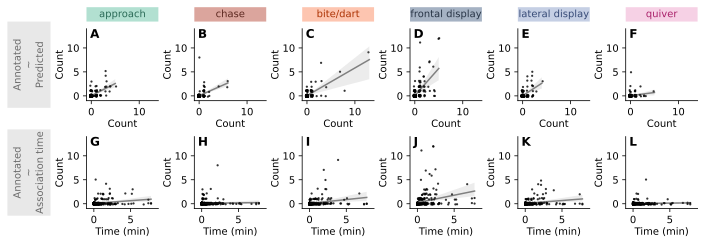

In [22]:
import seaborn as sns

figsize = (9, 2.6)
fig = plt.figure(figsize=figsize)

panel = vis.Panel(*figsize, extent=(0, 0, *figsize))

top, bottom = panel.divide(sizes_absolute=[1, 1], spacing_absolute=0.5, orientation="vertical")

panels_count = top.divide(sizes_absolute=[1] * 6, spacing_absolute=0.5, orientation="horizontal")
panel_association = bottom.divide(sizes_absolute=[1] * 6, spacing_absolute=0.5, orientation="horizontal")

labels_count = ["A", "B", "C", "D", "E", "F"]
labels_association = ["G", "H", "I", "J", "K", "L"]
axes_count = [panel.get_ax(fig, label=labels_count.pop(0), label_offset=(0.05, 0)) for panel in panels_count]
axes_association = [panel.get_ax(fig, label=labels_association.pop(0), label_offset=(0.05, 0)) for panel in panel_association]

aggregated_counts["duration_associated_min"] = aggregated_counts["duration_associated"] / (30 * 60)

max_association = aggregated_counts["duration_associated_min"].max()
max_count = np.asarray(aggregated_counts[["count_predicted", "count_annotated"]]).max()

for idx, subset in enumerate(category_subsets):

    interaction_counts = aggregated_counts.loc[aggregated_counts["categories_subset"] == subset]
    n_dyads = len(interaction_counts)
    
    sns.regplot(
        data=interaction_counts,
        x="count_predicted",
        y="count_annotated",
        ax=axes_count[idx],
        x_jitter=0.2,
        y_jitter=0.2,
        scatter_kws=dict(s=5, color="k", linewidths=0),
        line_kws=dict(lw=1.5, color="gray", zorder=-1),
    )
    
    sns.regplot(
        data=interaction_counts,
        x="duration_associated_min",
        y="count_annotated",
        ax=axes_association[idx],
        y_jitter=0.2,
        scatter_kws=dict(s=5, color="k", linewidths=0),
        line_kws=dict(lw=1.5, color="gray", zorder=-1),
    )
    axes_count[idx].set_xlim(-1, max_count + 1)
    axes_count[idx].set_ylim(-1, max_count + 1)
    axes_association[idx].set_xlim(-1, max_association + 1)
    axes_association[idx].set_ylim(-1, max_count + 1)

    axes_count[idx].set_ylabel("Count", labelpad=2)
    axes_count[idx].set_xlabel("Count", labelpad=2)
    axes_association[idx].set_ylabel("Count", labelpad=2)
    axes_association[idx].set_xlabel("Time (min)", labelpad=2)
    


def get_xtick_box(ax, factor=1):
    return np.mean(ax.get_xlim()), np.diff(ax.get_xlim())[0] * factor, ax

def get_ytick_box(ax, factor=1):
    return np.mean(ax.get_ylim()), np.diff(ax.get_ylim())[0] * factor, ax

for ax, subset, color in zip(axes_count, category_subsets, np.array(colors)[foreground]):
    category = subset
    if category == "dart_bite":
        category = "bite/dart"
    category = category.replace("_", " ")
    vis.add_xtick_box(*get_xtick_box(ax), y="top", text=category, color=color, offset_in_inches=0.1, **box_kwargs)

vis.add_ytick_box(
    *get_ytick_box(axes_count[0], 1.2), text="Annotated\n~\nPredicted",
    width_in_inches=0.6, offset_in_inches=0.5, color="lightgrey", **box_kwargs,
)
vis.add_ytick_box(
    *get_ytick_box(axes_association[0], 1.2), text="Annotated\n~\nAssociation time",
    width_in_inches=0.6, offset_in_inches=0.5, color="lightgrey", **box_kwargs,
)

plt.show()

## F1 scores summary

In [23]:
# f1 scores for all levels (timestamps, annotations, predictions)
# for all (post)processing steps, macro (foreground/all) or for each category

scores = []
formatted = {}

for f1 in ["timestamp", "annotation", "prediction"]:
    aggregated = manuscript_utils.aggregate_scores(summary, f"{f1}_f1", categories=dataset_test.categories).reset_index()
    aggregated["f1"] = f1
    scores.append(aggregated.set_index("f1"))

scores = pd.concat(scores).reset_index()
formatted["F1"] = scores["f1"]
formatted["Postprocessing step"] = scores["postprocessing_step"]

for column in scores.columns.droplevel(1)[2:]:
    column_formatted = column.replace("-", " (")
    if "(" in column_formatted:
        column_formatted += ")"
    column_formatted = column_formatted.replace("_", " ")
    formatted[column_formatted.capitalize()] = scores[column].apply(lambda values: f"{values["mean"]:.03f}±{values["std"]:.03f}", axis=1)

formatted = pd.DataFrame(formatted)
formatted.map(lambda s: s.replace("_", " ").capitalize())

,F1,Postprocessing step,Macro (foreground),Macro (all),Approach,Chase,Dart bite,Frontal display,Lateral display,None,Quiver
0,Timestamp,Model outputs,0.247±0.003,0.354±0.003,0.237±0.010,0.315±0.007,0.298±0.007,0.317±0.004,0.219±0.004,0.995±0.000,0.095±0.008
1,Timestamp,Smoothed,0.271±0.005,0.374±0.005,0.262±0.017,0.337±0.008,0.327±0.010,0.353±0.008,0.242±0.009,0.996±0.000,0.101±0.019
2,Timestamp,Thresholded,0.289±0.005,0.390±0.004,0.283±0.017,0.378±0.010,0.316±0.009,0.394±0.012,0.258±0.020,0.997±0.000,0.102±0.021
3,Annotation,Model outputs,0.552±0.013,0.605±0.012,0.495±0.035,0.535±0.014,0.614±0.022,0.674±0.014,0.586±0.031,0.919±0.003,0.409±0.069
4,Annotation,Smoothed,0.521±0.012,0.576±0.010,0.487±0.032,0.537±0.016,0.550±0.012,0.664±0.011,0.571±0.024,0.907±0.003,0.318±0.058
5,Annotation,Thresholded,0.482±0.015,0.536±0.013,0.542±0.035,0.557±0.024,0.524±0.015,0.524±0.020,0.426±0.031,0.864±0.003,0.316±0.064
6,Prediction,Model outputs,0.150±0.005,0.217±0.004,0.196±0.013,0.162±0.020,0.179±0.012,0.171±0.010,0.134±0.010,0.623±0.002,0.057±0.008
7,Prediction,Smoothed,0.303±0.008,0.375±0.007,0.335±0.023,0.290±0.017,0.385±0.021,0.387±0.009,0.279±0.017,0.805±0.004,0.145±0.031
8,Prediction,Thresholded,0.383±0.009,0.453±0.008,0.396±0.029,0.368±0.025,0.413±0.020,0.543±0.021,0.424±0.038,0.868±0.003,0.156±0.035


In [24]:
formatted.to_csv("f1_scores.csv", index=False)